# RAG Evaluation: Measuring Retrieval and Generation Quality

**Learning Objectives:**
- Understand key metrics for evaluating RAG systems
- Measure retrieval quality (precision, recall)
- Evaluate generation quality (faithfulness, relevance)
- Implement practical evaluation pipelines
- Learn best practices for RAG evaluation

## Setup

In [1]:
!pip install -q sentence-transformers numpy pandas matplotlib seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from sentence_transformers import SentenceTransformer

sns.set_style("whitegrid")
pd.set_option("display.max_colwidth", None)

## 1. Sample Dataset

Let's create a small knowledge base with questions and ground truth answers.

In [3]:
# Knowledge base documents
documents = [
    {
        "id": 0,
        "text": "Python is a high-level programming language known for its simplicity and readability.",
    },
    {
        "id": 1,
        "text": "Machine learning is a subset of AI that enables computers to learn from data.",
    },
    {
        "id": 2,
        "text": "Neural networks are computing systems inspired by biological neural networks.",
    },
    {
        "id": 3,
        "text": "Deep learning uses multi-layered neural networks to process complex patterns.",
    },
    {
        "id": 4,
        "text": "Natural language processing enables computers to understand human language.",
    },
    {
        "id": 5,
        "text": "Transformers are a type of neural network architecture for NLP tasks.",
    },
    {
        "id": 6,
        "text": "RAG combines retrieval and generation for knowledge-intensive tasks.",
    },
    {"id": 7, "text": "Vector databases store embeddings for fast similarity search."},
    {"id": 8, "text": "BERT is a transformer model pre-trained on large text corpora."},
    {"id": 9, "text": "Fine-tuning adapts pre-trained models to specific tasks."},
]

# Test queries with ground truth relevant document IDs
test_queries = [
    {
        "query": "What is machine learning?",
        "relevant_docs": [1, 3],  # Ground truth
        "expected_answer": "Machine learning is a subset of AI that enables computers to learn from data.",
    },
    {
        "query": "Explain neural networks",
        "relevant_docs": [2, 3],
        "expected_answer": "Neural networks are computing systems inspired by biological neural networks that can learn patterns.",
    },
    {
        "query": "What are transformers in NLP?",
        "relevant_docs": [5, 8],
        "expected_answer": "Transformers are a type of neural network architecture designed for NLP tasks.",
    },
    {
        "query": "How does RAG work?",
        "relevant_docs": [6, 7],
        "expected_answer": "RAG combines retrieval from knowledge bases and generation to answer knowledge-intensive questions.",
    },
]

print(f"Knowledge base: {len(documents)} documents")
print(f"Test queries: {len(test_queries)} queries")
print("\nExample query:")
print(f"  Q: {test_queries[0]['query']}")
print(f"  Relevant docs: {test_queries[0]['relevant_docs']}")

Knowledge base: 10 documents
Test queries: 4 queries

Example query:
  Q: What is machine learning?
  Relevant docs: [1, 3]


## 2. Simple Retrieval System

Create a basic retrieval system using embeddings.

In [4]:
class SimpleRetriever:
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)
        self.documents = None
        self.doc_embeddings = None

    def index(self, documents: List[Dict]):
        """Index documents by computing their embeddings."""
        self.documents = documents
        texts = [doc["text"] for doc in documents]
        self.doc_embeddings = self.model.encode(texts, convert_to_numpy=True)
        print(f"✓ Indexed {len(documents)} documents")

    def retrieve(self, query: str, k: int = 3) -> List[Dict]:
        """Retrieve top-k most similar documents."""
        query_embedding = self.model.encode(query, convert_to_numpy=True)

        # Compute cosine similarity
        similarities = np.dot(self.doc_embeddings, query_embedding) / (
            np.linalg.norm(self.doc_embeddings, axis=1)
            * np.linalg.norm(query_embedding)
        )

        # Get top-k indices
        top_k_indices = np.argsort(similarities)[::-1][:k]

        # Return documents with scores
        results = [
            {
                "doc_id": self.documents[idx]["id"],
                "text": self.documents[idx]["text"],
                "score": float(similarities[idx]),
                "rank": rank + 1,
            }
            for rank, idx in enumerate(top_k_indices)
        ]

        return results


retriever = SimpleRetriever()
retriever.index(documents)

✓ Indexed 10 documents


## 3. Retrieval Evaluation Metrics

### Key Metrics:
- **Precision@K**: What fraction of retrieved docs are relevant?
- **Recall@K**: What fraction of relevant docs were retrieved?

In [6]:
def precision_at_k(
    retrieved_ids: List[int], relevant_ids: List[int], k: int = None
) -> float:
    """
    Calculate Precision@K.

    Formula: |retrieved ∩ relevant| / k
    """
    if k:
        retrieved_ids = retrieved_ids[:k]

    relevant_retrieved = len(set(retrieved_ids) & set(relevant_ids))
    return relevant_retrieved / len(retrieved_ids) if retrieved_ids else 0.0


def recall_at_k(
    retrieved_ids: List[int], relevant_ids: List[int], k: int = None
) -> float:
    """
    Calculate Recall@K.

    Formula: |retrieved ∩ relevant| / |relevant|
    """
    if k:
        retrieved_ids = retrieved_ids[:k]

    relevant_retrieved = len(set(retrieved_ids) & set(relevant_ids))
    return relevant_retrieved / len(relevant_ids) if relevant_ids else 0.0


# Test the metrics with an example
example_retrieved = [1, 5, 2, 7]
example_relevant = [1, 3, 2]

print("Example Evaluation:")
print(f"  Retrieved: {example_retrieved}")
print(f"  Relevant:  {example_relevant}")
print(
    f"\n  Precision@4: {precision_at_k(example_retrieved, example_relevant, k=4):.3f}"
)
print(f"  Recall@4:    {recall_at_k(example_retrieved, example_relevant, k=4):.3f}")

Example Evaluation:
  Retrieved: [1, 5, 2, 7]
  Relevant:  [1, 3, 2]

  Precision@4: 0.500
  Recall@4:    0.667


## 4. Evaluate Retrieval System

In [9]:
def evaluate_retrieval(retriever, test_queries: List[Dict], k: int = 5) -> pd.DataFrame:
    """
    Evaluate retriever on all test queries.
    """
    results = []

    for test_case in test_queries:
        query = test_case["query"]
        relevant_ids = test_case["relevant_docs"]

        # Retrieve documents
        retrieved = retriever.retrieve(query, k=k)
        retrieved_ids = [doc["doc_id"] for doc in retrieved]

        # Calculate metrics
        metrics = {
            "query": query,
            "retrieved_ids": retrieved_ids,
            "relevant_ids": relevant_ids,
            "precision@3": precision_at_k(retrieved_ids, relevant_ids, k=3),
            "recall@3": recall_at_k(retrieved_ids, relevant_ids, k=3),
            "precision@5": precision_at_k(retrieved_ids, relevant_ids, k=5),
            "recall@5": recall_at_k(retrieved_ids, relevant_ids, k=5),
        }
        results.append(metrics)

    return pd.DataFrame(results)


eval_results = evaluate_retrieval(retriever, test_queries, k=5)

print("=" * 100)
print("RETRIEVAL EVALUATION RESULTS")
print("=" * 100)
print(eval_results[["query", "precision@3", "recall@3"]].to_string(index=False))

print("\n" + "=" * 100)
print("AVERAGE METRICS")
print("=" * 100)
avg_metrics = eval_results[
    ["precision@3", "recall@3", "precision@5", "recall@5"]
].mean()
for metric, value in avg_metrics.items():
    print(f"  {metric}: {value:.3f}")

RETRIEVAL EVALUATION RESULTS
                        query  precision@3  recall@3
    What is machine learning?     0.666667       1.0
      Explain neural networks     0.666667       1.0
What are transformers in NLP?     0.666667       1.0
           How does RAG work?     0.333333       0.5

AVERAGE METRICS
  precision@3: 0.583
  recall@3: 0.875
  precision@5: 0.350
  recall@5: 0.875


## 5. Visualize Retrieval Performance

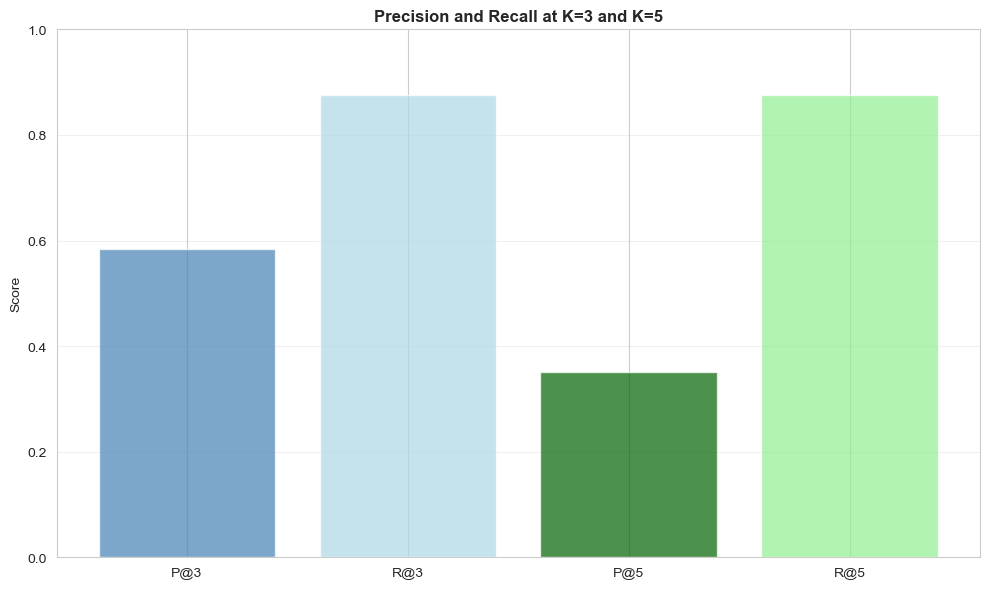

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics_to_plot = ["precision@3", "recall@3", "precision@5", "recall@5"]
avg_values = [eval_results[m].mean() for m in metrics_to_plot]
colors = ["steelblue", "lightblue", "darkgreen", "lightgreen"]

ax.bar(range(len(metrics_to_plot)), avg_values, color=colors, alpha=0.7)
ax.set_xticks(range(len(metrics_to_plot)))
ax.set_xticklabels(["P@3", "R@3", "P@5", "R@5"])
ax.set_ylabel("Score")
ax.set_title("Precision and Recall at K=3 and K=5", fontweight="bold")
ax.set_ylim(0, 1)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Generation Evaluation Metrics

### Key Metrics:
- **Faithfulness**: Is the answer grounded in retrieved context?
- **Answer Relevance**: Does the answer address the question?
- **Context Relevance**: Are retrieved docs relevant to the question?
- **Semantic Similarity**: How similar is the answer to expected answer?

In [16]:
class GenerationEvaluator:
    def __init__(self, model_name: str = "all-MiniLM-L6-v2"):
        self.model = SentenceTransformer(model_name)

    def semantic_similarity(self, text1: str, text2: str) -> float:
        """
        Calculate cosine similarity between two texts.
        """
        emb1 = self.model.encode(text1, convert_to_numpy=True)
        emb2 = self.model.encode(text2, convert_to_numpy=True)

        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        return float(similarity)

    def faithfulness_score(self, answer: str, context: str) -> float:
        """
        Measure if answer is grounded in context.
        Simple version: semantic similarity between answer and context.
        """
        return self.semantic_similarity(answer, context)

    def answer_relevance(self, answer: str, question: str) -> float:
        """
        Measure if answer addresses the question.
        """
        return self.semantic_similarity(answer, question)

    def context_relevance(self, context: str, question: str) -> float:
        """
        Measure if context is relevant to question.
        """
        return self.semantic_similarity(context, question)

    def evaluate_generation(
        self, question: str, answer: str, context: str, expected_answer: str = None
    ) -> Dict[str, float]:
        """
        Comprehensive generation evaluation.
        """
        metrics = {
            "faithfulness": self.faithfulness_score(answer, context),
            "answer_relevance": self.answer_relevance(answer, question),
            "context_relevance": self.context_relevance(context, question),
        }

        if expected_answer:
            metrics["answer_similarity"] = self.semantic_similarity(
                answer, expected_answer
            )

        return metrics


gen_evaluator = GenerationEvaluator()
print("✓ Generation evaluator initialized")

✓ Generation evaluator initialized


## 7. Simulate RAG System and Evaluate

In [17]:
def simulate_rag_answer(query: str, retrieved_docs: List[Dict]) -> str:
    """
    Simulate LLM answer generation from retrieved docs.
    (In real systems, this would call an actual LLM)
    """
    # Simple simulation: concatenate top retrieved docs
    context_parts = [doc["text"] for doc in retrieved_docs[:2]]

    # Simulate answer as summary of context (simplified)
    answer = f"Based on the context: {' '.join(context_parts[:100])}..."
    return answer


# Evaluate end-to-end RAG system
rag_eval_results = []

for test_case in test_queries:
    query = test_case["query"]
    expected_answer = test_case["expected_answer"]

    # Retrieve
    retrieved_docs = retriever.retrieve(query, k=3)
    context = " ".join([doc["text"] for doc in retrieved_docs])

    # Generate (simulated)
    generated_answer = simulate_rag_answer(query, retrieved_docs)

    # Evaluate generation
    gen_metrics = gen_evaluator.evaluate_generation(
        question=query,
        answer=generated_answer,
        context=context,
        expected_answer=expected_answer,
    )

    result = {"query": query, "answer": generated_answer[:80] + "...", **gen_metrics}
    rag_eval_results.append(result)

rag_df = pd.DataFrame(rag_eval_results)

print("=" * 100)
print("RAG GENERATION EVALUATION")
print("=" * 100)
print(
    rag_df[
        [
            "query",
            "faithfulness",
            "answer_relevance",
            "context_relevance",
            "answer_similarity",
        ]
    ].to_string(index=False)
)

print("\n" + "=" * 100)
print("AVERAGE GENERATION METRICS")
print("=" * 100)
avg_gen_metrics = rag_df[
    ["faithfulness", "answer_relevance", "context_relevance", "answer_similarity"]
].mean()
for metric, value in avg_gen_metrics.items():
    print(f"  {metric}: {value:.3f}")

RAG GENERATION EVALUATION
                        query  faithfulness  answer_relevance  context_relevance  answer_similarity
    What is machine learning?      0.865616          0.755432           0.749816           0.860531
      Explain neural networks      0.765953          0.637348           0.621651           0.834113
What are transformers in NLP?      0.974265          0.744246           0.753333           0.849922
           How does RAG work?      0.928084          0.402899           0.401227           0.684889

AVERAGE GENERATION METRICS
  faithfulness: 0.883
  answer_relevance: 0.635
  context_relevance: 0.632
  answer_similarity: 0.807


## 8. Visualize Generation Quality

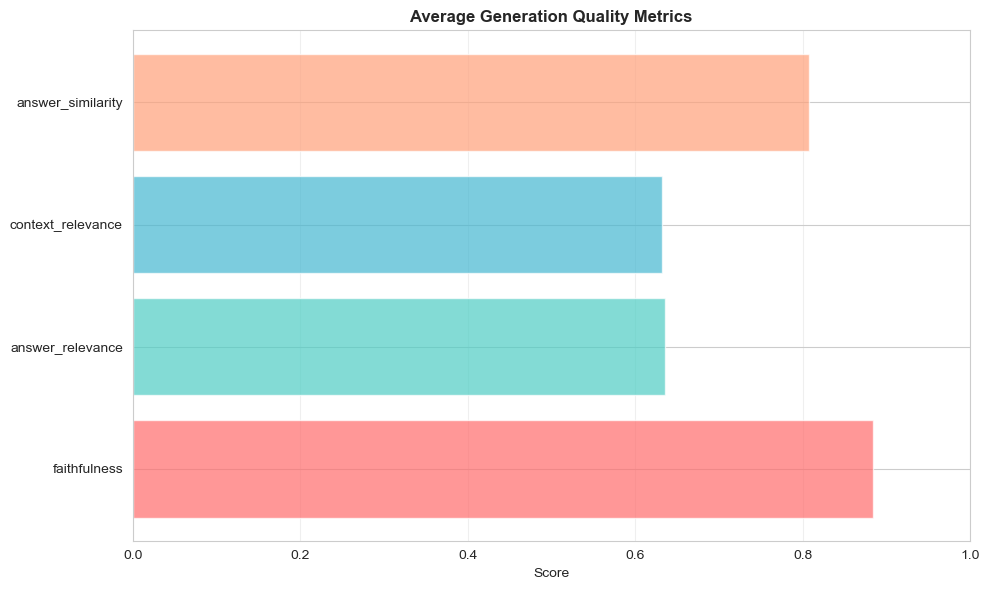

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot 1: Average generation metrics
metrics = ["faithfulness", "answer_relevance", "context_relevance", "answer_similarity"]
values = [rag_df[m].mean() for m in metrics]
colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#FFA07A"]

ax.barh(metrics, values, color=colors, alpha=0.7)
ax.set_xlabel("Score")
ax.set_title("Average Generation Quality Metrics", fontweight="bold")
ax.set_xlim(0, 1)
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Complete RAG Evaluation Pipeline

In [ ]:
def evaluate_rag_system(
    retriever, test_queries: List[Dict], k: int = 5
) -> Dict[str, pd.DataFrame]:
    """
    Complete evaluation pipeline for RAG system.

    Returns:
        Dictionary with retrieval and generation evaluation dataframes
    """
    gen_evaluator = GenerationEvaluator()

    all_results = []

    for test_case in test_queries:
        query = test_case["query"]
        relevant_ids = test_case["relevant_docs"]
        expected_answer = test_case["expected_answer"]

        # Retrieval
        retrieved_docs = retriever.retrieve(query, k=k)
        retrieved_ids = [doc["doc_id"] for doc in retrieved_docs]
        context = " ".join([doc["text"] for doc in retrieved_docs])

        # Retrieval metrics
        retrieval_metrics = {
            "precision@3": precision_at_k(retrieved_ids, relevant_ids, k=3),
            "recall@3": recall_at_k(retrieved_ids, relevant_ids, k=3),
        }

        # Generation
        generated_answer = simulate_rag_answer(query, retrieved_docs)

        # Generation metrics
        generation_metrics = gen_evaluator.evaluate_generation(
            question=query,
            answer=generated_answer,
            context=context,
            expected_answer=expected_answer,
        )

        # Combine
        result = {"query": query, **retrieval_metrics, **generation_metrics}
        all_results.append(result)

    results_df = pd.DataFrame(all_results)

    return results_df


# Run complete evaluation
complete_eval = evaluate_rag_system(retriever, test_queries, k=5)

print("=" * 100)
print("COMPLETE RAG SYSTEM EVALUATION")
print("=" * 100)
print(complete_eval.to_string(index=False))

print("\n" + "=" * 100)
print("OVERALL SYSTEM PERFORMANCE")
print("=" * 100)
numeric_cols = complete_eval.select_dtypes(include=[np.number]).columns
avg_all = complete_eval[numeric_cols].mean()
for metric, value in avg_all.items():
    print(f"  {metric}: {value:.3f}")

COMPLETE RAG SYSTEM EVALUATION
                        query  precision@3  recall@3  mrr   ndcg@5  faithfulness  answer_relevance  context_relevance  answer_similarity
    What is machine learning?     0.666667       1.0  1.0 0.919721      0.807438          0.755432           0.708844           0.860531
      Explain neural networks     0.666667       1.0  1.0 1.000000      0.736027          0.637348           0.627755           0.834113
What are transformers in NLP?     0.666667       1.0  1.0 1.000000      0.904271          0.744246           0.693945           0.849922
           How does RAG work?     0.333333       0.5  1.0 0.613147      0.882092          0.402899           0.385017           0.684889

OVERALL SYSTEM PERFORMANCE
  precision@3: 0.583
  recall@3: 0.875
  mrr: 1.000
  ndcg@5: 0.883
  faithfulness: 0.832
  answer_relevance: 0.635
  context_relevance: 0.604
  answer_similarity: 0.807


## 10. Summary Dashboard

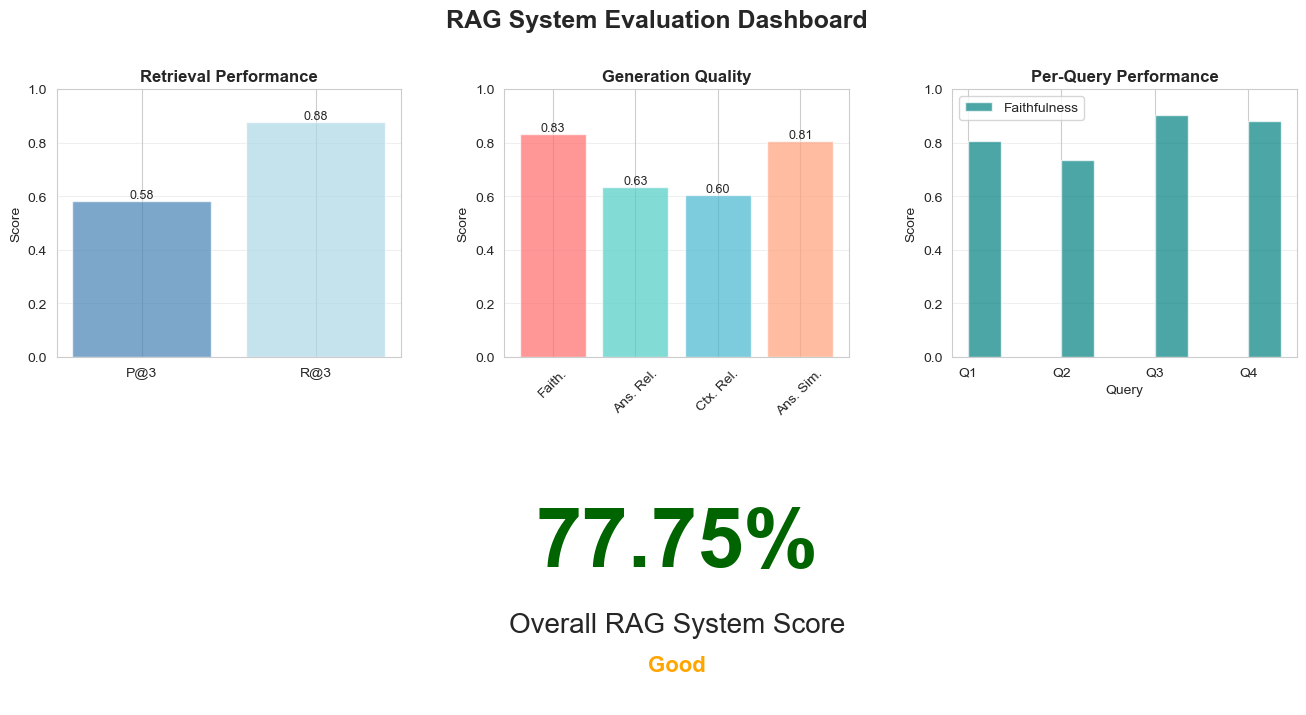

In [26]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Retrieval metrics bar chart (changed from polar)
ax1 = fig.add_subplot(gs[0, 0])
retrieval_metrics = ["precision@3", "recall@3"]
values = [complete_eval[m].mean() for m in retrieval_metrics]
bars = ax1.bar(
    range(len(retrieval_metrics)), values, color=["steelblue", "lightblue"], alpha=0.7
)
ax1.set_xticks(range(len(retrieval_metrics)))
ax1.set_xticklabels(["P@3", "R@3"])
ax1.set_ylabel("Score")
ax1.set_ylim(0, 1)
ax1.set_title("Retrieval Performance", fontweight="bold")
ax1.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# 2. Generation metrics bar chart
ax2 = fig.add_subplot(gs[0, 1])
gen_metrics = [
    "faithfulness",
    "answer_relevance",
    "context_relevance",
    "answer_similarity",
]
gen_values = [complete_eval[m].mean() for m in gen_metrics]
bars = ax2.bar(
    range(len(gen_metrics)),
    gen_values,
    color=["#FF6B6B", "#4ECDC4", "#45B7D1", "#FFA07A"],
    alpha=0.7,
)
ax2.set_xticks(range(len(gen_metrics)))
ax2.set_xticklabels(["Faith.", "Ans. Rel.", "Ctx. Rel.", "Ans. Sim."], rotation=45)
ax2.set_ylabel("Score")
ax2.set_ylim(0, 1)
ax2.set_title("Generation Quality", fontweight="bold")
ax2.grid(axis="y", alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.2f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

# 3. Per-query performance
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(complete_eval))
width = 0.35
ax3.bar(
    x + width / 2,
    complete_eval["faithfulness"],
    width,
    label="Faithfulness",
    alpha=0.7,
    color="teal",
)
ax3.set_xlabel("Query")
ax3.set_ylabel("Score")
ax3.set_title("Per-Query Performance", fontweight="bold")
ax3.set_xticks(x)
ax3.set_xticklabels([f"Q{i+1}" for i in range(len(complete_eval))])
ax3.legend()
ax3.set_ylim(0, 1)
ax3.grid(axis="y", alpha=0.3)

# 4. Overall score gauge
ax4 = fig.add_subplot(gs[1, :])
overall_score = complete_eval[numeric_cols].mean().mean()
ax4.text(
    0.5,
    0.6,
    f"{overall_score:.2%}",
    ha="center",
    va="center",
    fontsize=60,
    fontweight="bold",
    color="darkgreen",
)
ax4.text(0.5, 0.3, "Overall RAG System Score", ha="center", va="center", fontsize=20)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis("off")

# Add performance category
if overall_score >= 0.8:
    category = "Excellent"
    color = "green"
elif overall_score >= 0.6:
    category = "Good"
    color = "orange"
else:
    category = "Needs Improvement"
    color = "red"

ax4.text(
    0.5,
    0.15,
    category,
    ha="center",
    va="center",
    fontsize=16,
    color=color,
    fontweight="bold",
)

plt.suptitle("RAG System Evaluation Dashboard", fontsize=18, fontweight="bold", y=0.98)
plt.show()

## 11. Key Takeaways

### Best Practices

1. **Create ground truth datasets** with labeled relevant documents
2. **Evaluate both retrieval and generation** separately
3. **Track metrics over time** to monitor improvements
4. **Use multiple metrics** for comprehensive evaluation
5. **Consider task-specific metrics** based on your use case
6. **A/B test changes** before deploying to production
7. **Collect user feedback** as the ultimate evaluation

### Common Issues and Solutions

- **Low Precision**: Retriever returns irrelevant docs → Improve embeddings or add reranking
- **Low Recall**: Missing relevant docs → Increase K or improve chunking strategy
- **Low Faithfulness**: Hallucinations → Better prompting or instruction tuning
- **Low Answer Relevance**: Off-topic answers → Improve context selection or prompt engineering